In [1]:
!pip install matplotlib nltk numpy pandas scikit-learn scipy seaborn torch

In [2]:
# # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/dataset'

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
from nltk.corpus import stopwords

DATA CLEANING

In [4]:
from pathlib import Path

dataset = Path(DATASET_PATH)

data1 = pd.read_csv(dataset / 'spam.csv',delimiter=',',encoding='latin-1').drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1).rename(columns={'v1':'type', 'v2':'text'})
data2 = pd.read_csv(dataset / 'spamraw.csv',delimiter=',',encoding='latin-1')
data3 = pd.read_csv(dataset / 'real.csv',delimiter=',',encoding='latin-1')

df = pd.concat([data1, data2, data3], ignore_index=True)

In [5]:
df = df.rename(columns={'type':'label', 'text':'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,label,message
count,11171,11171
unique,2,6106
top,ham,"Sorry, I'll call later"
freq,9669,60


Text(0.5, 1.0, 'Number of ham and spam messages')

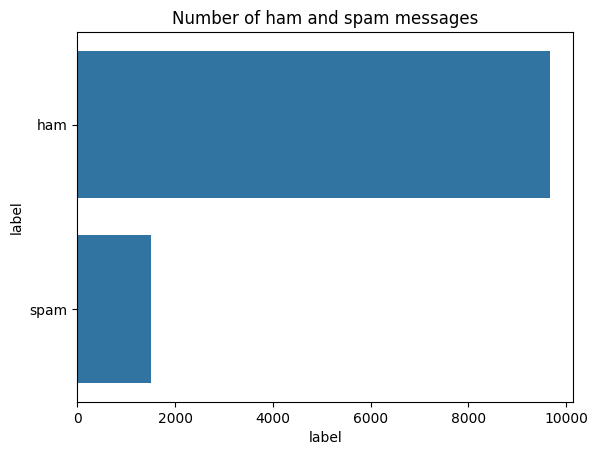

In [7]:
sns.countplot(df.label)
plt.xlabel('label')
plt.title('Number of ham and spam messages')

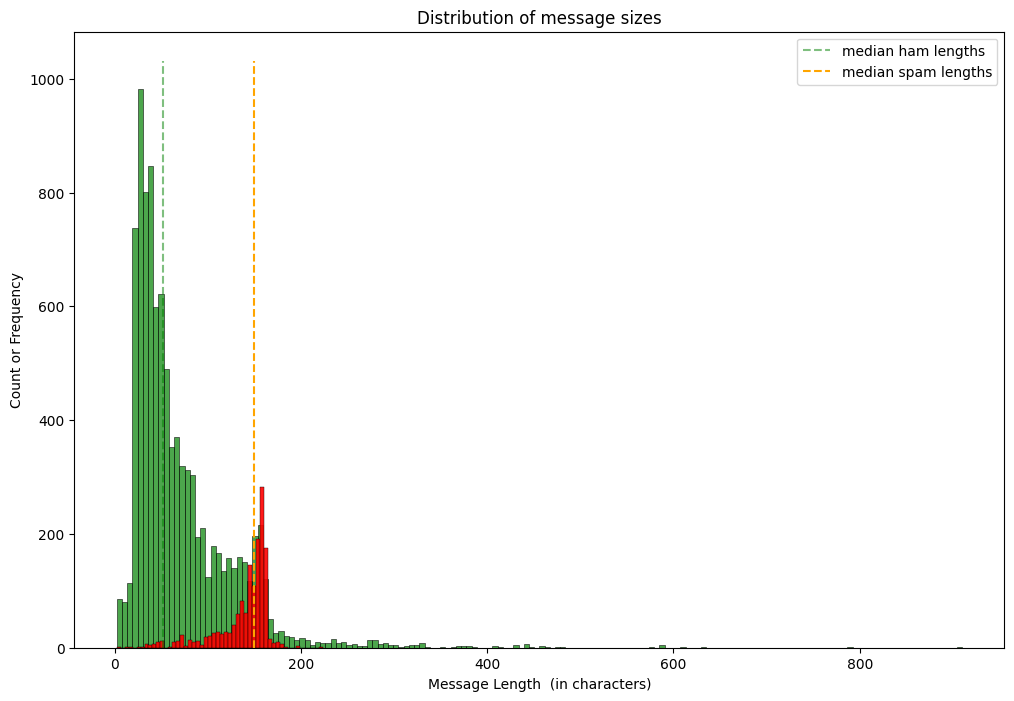

In [8]:
df['len'] = df['message'].apply(len)
fig,ax=plt.subplots(figsize=(12,8))
check = 'ham'
sns.histplot(df[df['label']==check],x='len',color='green',ax=ax,alpha=0.7)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='green',alpha=0.5,linestyles='dashed')
check = 'spam'
sns.histplot(df[df['label']==check],x='len',color='red',ax=ax,alpha=0.9)
plt.vlines(x=df.loc[df['label']==check,'len'].median(),ymin=ymin,ymax=ymax,color='orange',linestyles='dashed')

plt.legend(['median ham lengths','median spam lengths'])
_=plt.title('Distribution of message sizes')
_=plt.ylabel('Count or Frequency')
_=plt.xlabel('Message Length  (in characters)')

In [9]:
X = df.message
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

FEATURE EXTRACTION


In [10]:
from sklearn.pipeline import FeatureUnion
#FeatureUnion is used to concat feaatures obtained using different transform functions
from sklearn.preprocessing import FunctionTransformer
#FunctionTransformer can create a transform function from any arbitrary or user defined function
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.manifold import TSNE

In [11]:
"""
Takes in a string of text, then normalize it:
"""

nltk.download('stopwords')
def text_perprocessing(message):
    # 1. Removes all punctuation
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # 2. Removes all stopwords
    stop_words = set(stopwords.words('english'))
    nostop = [word.lower() for word in nopunc.split() if word.lower() not in stop_words]

    return " ".join(nostop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


COUNT VECTORIZER

In [12]:
cv = CountVectorizer(analyzer=text_perprocessing)
X_transform = cv.fit_transform(X)

TF-IDF

In [13]:
def get_length(df): return csr_matrix(df.apply(len).to_numpy().reshape(-1,1))

feature_pipe = FeatureUnion([('tfidf',TfidfVectorizer(analyzer=text_perprocessing)), ('length',FunctionTransformer(get_length))])

X_transform = feature_pipe.fit_transform(X)

(X_transform.toarray().size)

916022

TRANSFORMER BASED FEATURES

In [14]:
!pip install transformers==4.51.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [15]:
import torch
import transformers
from nltk.tokenize import word_tokenize
import numpy as np


In [16]:
import torch
import transformers
import numpy as np

# take over whatever gpus are on the system
device = 'cpu'
gpu_ids = []
if torch.cuda.is_available():
    gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
    device = torch.device(f'cuda:{gpu_ids[0]}')
    torch.cuda.set_device(device)
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

# Get max_len from the dataset for consistent padding
# This step still processes all messages to find the max length, which is efficient enough for this dataset size.
tokenized_lengths = df["message"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
max_len = tokenized_lengths.max()

# Tokenize and encode all messages at once, handling padding and attention masks
# This is more efficient than manual padding and mask creation as `tokenizer.batch_encode_plus` is optimized.
encoded_inputs = tokenizer.batch_encode_plus(
    df["message"].tolist(),
    add_special_tokens=True,
    max_length=max_len, # Use the determined max length
    padding='max_length', # Pad to max_len
    truncation=True, # Truncate if a message is longer than max_len (or model's max input length)
    return_attention_mask=True,
    return_tensors='pt' # Return PyTorch tensors
)

input_ids_tensor = encoded_inputs['input_ids']
attention_mask_tensor = encoded_inputs['attention_mask']

model = model.to(device)

# Batch processing to avoid OutOfMemoryError
batch_size = 32 # You can adjust this value based on your GPU memory
all_hidden_states = []

with torch.no_grad():
    for i in range(0, len(input_ids_tensor), batch_size):
        batch_input_ids = input_ids_tensor[i:i+batch_size].to(device)
        batch_attention_mask = attention_mask_tensor[i:i+batch_size].to(device)

        # Get hidden states
        batch_encoder_hidden_state = model(batch_input_ids, attention_mask=batch_attention_mask)
        # Extract the [CLS] token's hidden state and move to CPU
        all_hidden_states.append(batch_encoder_hidden_state[0][:,0,:].cpu().numpy())

# Concatenate all batch results
X = np.concatenate(all_hidden_states, axis=0)

# Ensure 'num_words' column exists before hstack
df['num_words'] = df['message'].apply(lambda x: len(str(x).split()))
# For 'message_len', assuming it refers to df['len'] which is already calculated.
X_transform = np.hstack((X, df[["num_words", "len"]].to_numpy().reshape(-1, 2))) # using 'len' as 'message_len'

Using GPU: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TEXT2SEQ

In [17]:
!pip install tensorflow-text

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

%matplotlib inline

In [19]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(df['message'])
sequences = tok.texts_to_sequences(df['message'])
X_transform = pad_sequences(sequences,maxlen=max_len)

In [20]:
# SPLIT DATASETß
X_train,X_test,Y_train,Y_test = train_test_split(X_transform,Y,test_size=0.2)

TRADITIONAL ML MODELS


In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve

In [22]:
def eval_result(X_test, y_test, pred):
  print(classification_report(y_test, pred, target_names = ['Ham', 'Spam']))
  display(pd.DataFrame(confusion_matrix(y_test, pred),
                    columns = ['Predicted Ham', 'Predicted Spam'],
                    index = ['Ham', 'Spam']))

  print(f'Accuracy: {round(accuracy_score(y_test, pred), 5)}')

  fig = plt.figure(figsize=(10,4))
  heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, pred)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.ylabel('Ground Truth')
  plt.xlabel('Prediction')
  plt.show()

  precision, recall, thresholds = precision_recall_curve(y_test, pred)

  fig, ax = plt.subplots(figsize=(6,6))
  ax.plot(recall, precision, label='Model')
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.legend(loc='center left');

              precision    recall  f1-score   support

         Ham       0.94      0.78      0.85      1916
        Spam       0.35      0.72      0.47       319

    accuracy                           0.77      2235
   macro avg       0.65      0.75      0.66      2235
weighted avg       0.86      0.77      0.80      2235



,Predicted Ham,Predicted Spam
Ham,1493,423
Spam,90,229


Accuracy: 0.77047


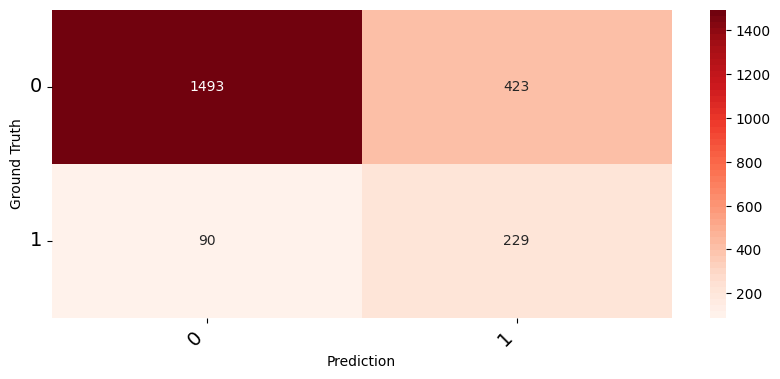

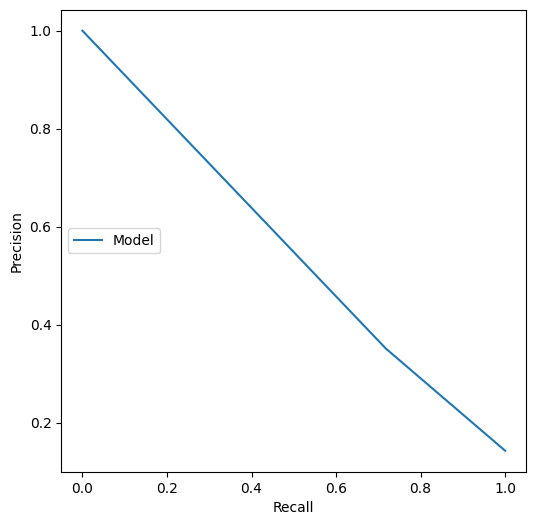

In [23]:
# NAIVE BAYES
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, Y_train.reshape(len(Y_train), ))

nb_pred = nb.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), nb_pred)

              precision    recall  f1-score   support

         Ham       0.89      0.97      0.93      1916
        Spam       0.64      0.28      0.39       319

    accuracy                           0.87      2235
   macro avg       0.76      0.63      0.66      2235
weighted avg       0.85      0.87      0.85      2235



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predicted Ham,Predicted Spam
Ham,1865,51
Spam,230,89


Accuracy: 0.87427


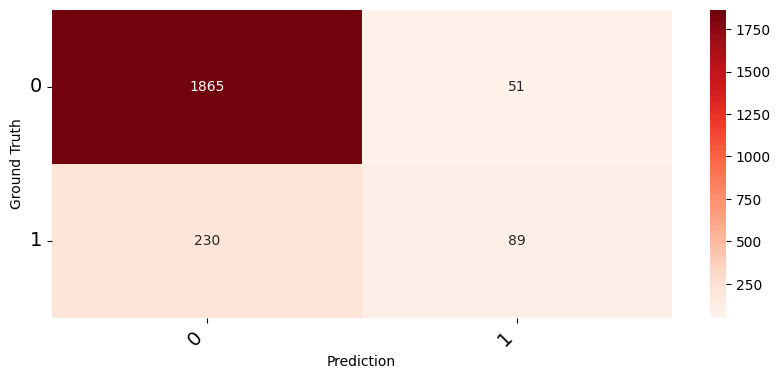

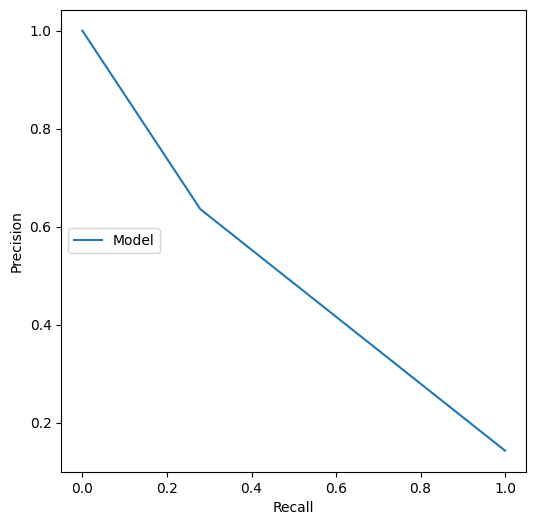

In [24]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, Y_train.reshape(len(Y_train), ))

lr_pred = lr.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), lr_pred)

              precision    recall  f1-score   support

         Ham       0.93      0.99      0.96      1916
        Spam       0.92      0.53      0.67       319

    accuracy                           0.93      2235
   macro avg       0.92      0.76      0.82      2235
weighted avg       0.93      0.93      0.92      2235



,Predicted Ham,Predicted Spam
Ham,1901,15
Spam,150,169


Accuracy: 0.92617


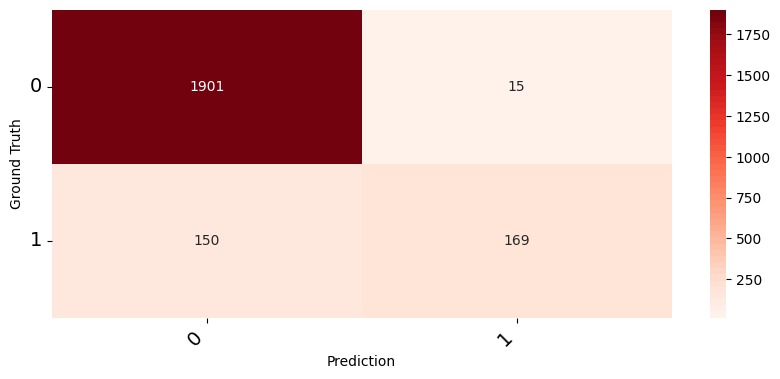

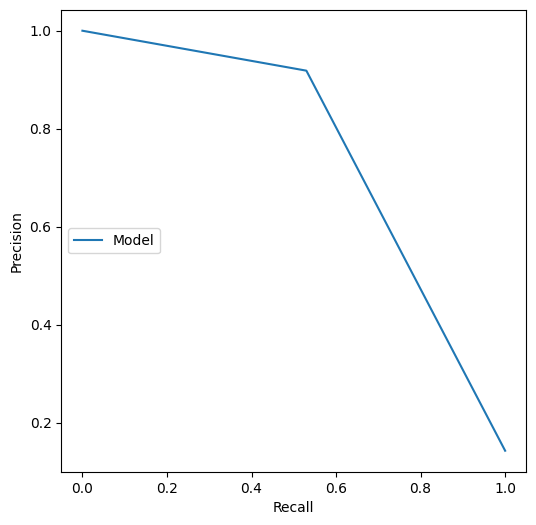

In [25]:
# SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, Y_train.reshape(len(Y_train), ))

svm_pred = svm.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), svm_pred)

              precision    recall  f1-score   support

         Ham       0.93      0.99      0.96      1916
        Spam       0.90      0.58      0.70       319

    accuracy                           0.93      2235
   macro avg       0.92      0.78      0.83      2235
weighted avg       0.93      0.93      0.92      2235



,Predicted Ham,Predicted Spam
Ham,1895,21
Spam,134,185


Accuracy: 0.93065


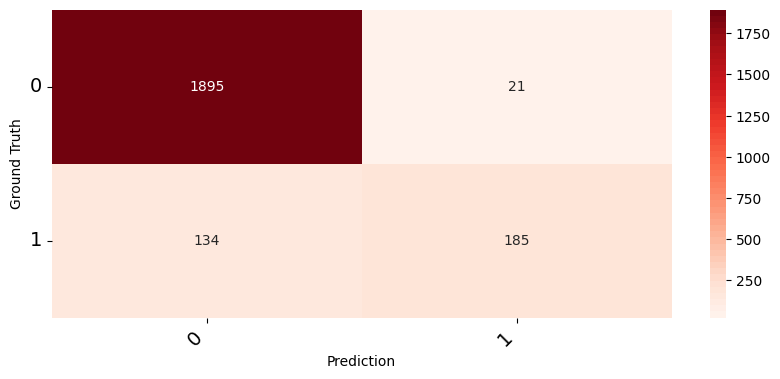

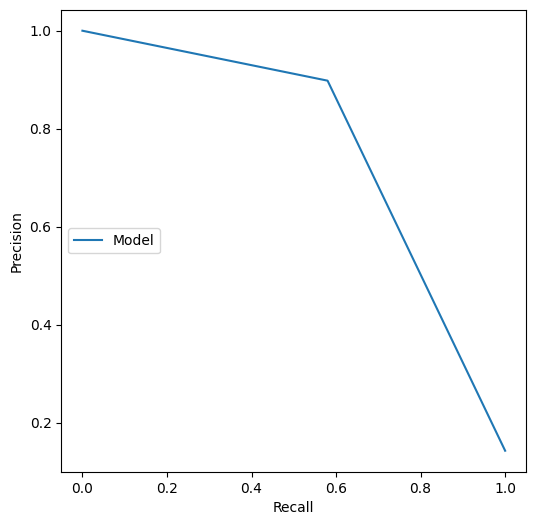

In [26]:
# K-NEAREST NEIGHBORS
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, Y_train.reshape(len(Y_train), ))

neigh_pred = neigh.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), neigh_pred)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1916
        Spam       0.99      0.91      0.95       319

    accuracy                           0.99      2235
   macro avg       0.99      0.96      0.97      2235
weighted avg       0.99      0.99      0.99      2235



,Predicted Ham,Predicted Spam
Ham,1914,2
Spam,28,291


Accuracy: 0.98658


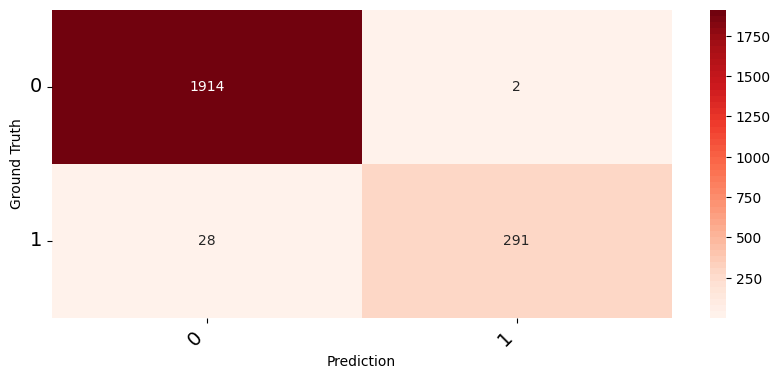

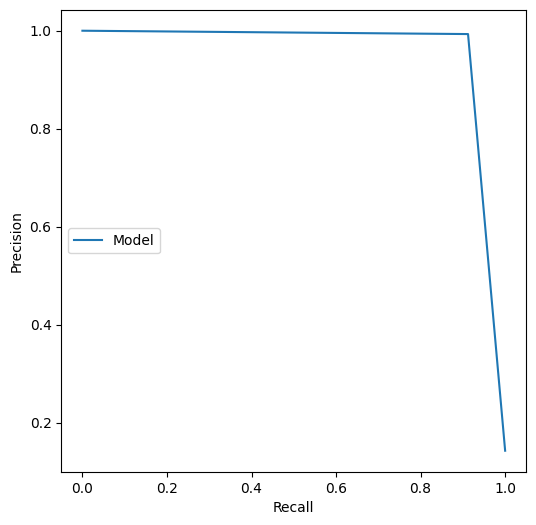

In [27]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs = -1, random_state = 1)
rfc.fit(X_train, Y_train.reshape(len(Y_train), ))

rfc_pred = rfc.predict(X_test)
eval_result(X_test, Y_test.reshape(len(Y_test), ), rfc_pred)

DEEP LEARNING MODELS

LSTM

In [28]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Convolution1D, MaxPooling1D, Flatten, LeakyReLU, ReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [29]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Dropout(0.4)(layer)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = LeakyReLU(alpha=0.1)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)

    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,337 (376.32 KB)

 Trainable params: 96,337 (376.32 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.8488 - loss: 0.3904 - val_accuracy: 0.9726 - val_loss: 0.0958
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9754 - loss: 0.0901 - val_accuracy: 0.9771 - val_loss: 0.0758
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9871 - loss: 0.0519 - val_accuracy: 0.9866 - val_loss: 0.0477
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9867 - loss: 0.0408 - val_accuracy: 0.9860 - val_loss: 0.0538


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99      1916
        Spam       1.00      0.89      0.94       319

    accuracy                           0.98      2235
   macro avg       0.99      0.94      0.96      2235
weighted avg       0.98      0.98      0.98      2235



,Predicted Ham,Predicted Spam
Ham,1915,1
Spam,36,283


Accuracy: 0.98345


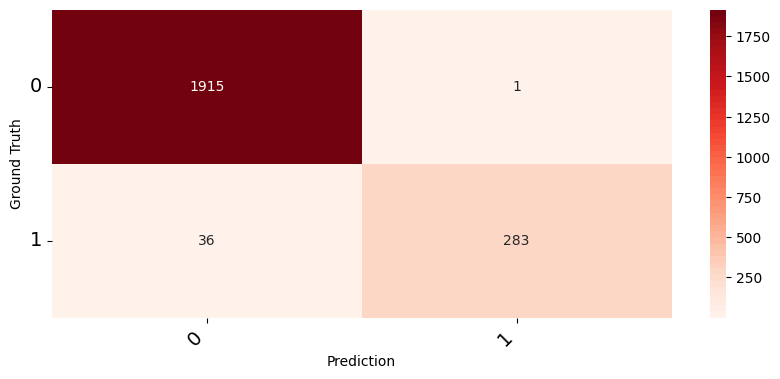

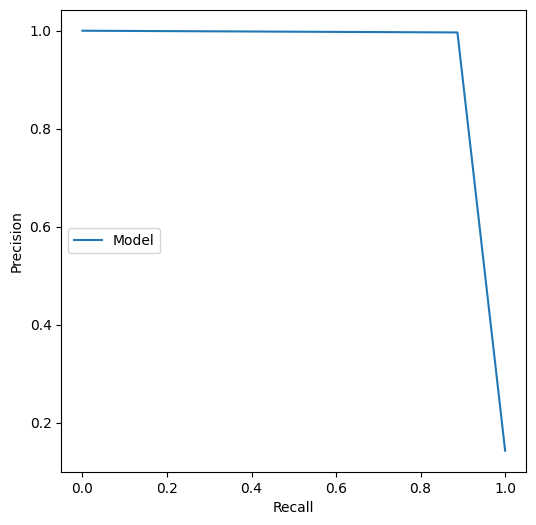

In [31]:
pred = model.predict(X_test)
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)

CNN

In [32]:
def CNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,64,input_length=max_len)(inputs)
    layer = Convolution1D(filters=32, kernel_size=3, input_shape=(max_len, 64))(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    layer = LeakyReLU(alpha=0.1)(layer)
    layer = Flatten()(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)

    return model

model = CNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 150, 64)        │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 148, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 74, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 74, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2368)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │         2,369 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,545 (283.38 KB)

 Trainable params: 72,545 (283.38 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.8177 - loss: 0.4090 - val_accuracy: 0.9234 - val_loss: 0.2556
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9250 - loss: 0.2186 - val_accuracy: 0.9709 - val_loss: 0.1075
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9748 - loss: 0.0896 - val_accuracy: 0.9793 - val_loss: 0.0673
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9810 - loss: 0.0592 - val_accuracy: 0.9860 - val_loss: 0.0527
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9875 - loss: 0.0426 - val_accuracy: 0.9894 - val_loss: 0.0460
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9904 - loss: 0.0358 - val_accuracy: 0.9899 - val_loss: 0.0409
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9930 - loss: 0.0266 - val_accuracy: 0.9911 - val_loss: 0.0373
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9945 - loss: 0.0210 - val_accuracy: 0

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1916
        Spam       0.98      0.94      0.96       319

    accuracy                           0.99      2235
   macro avg       0.98      0.97      0.98      2235
weighted avg       0.99      0.99      0.99      2235



,Predicted Ham,Predicted Spam
Ham,1909,7
Spam,18,301


Accuracy: 0.98881


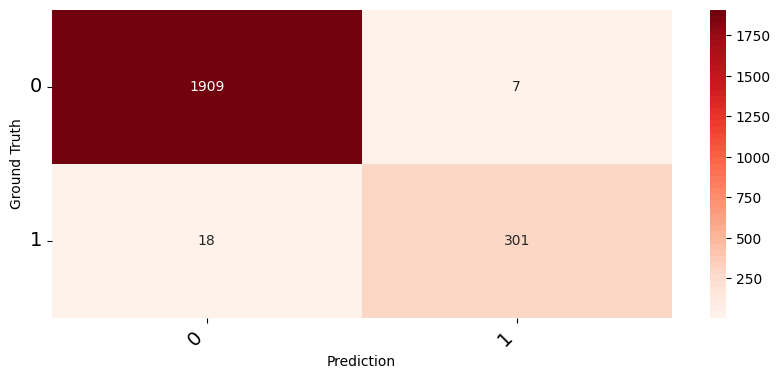

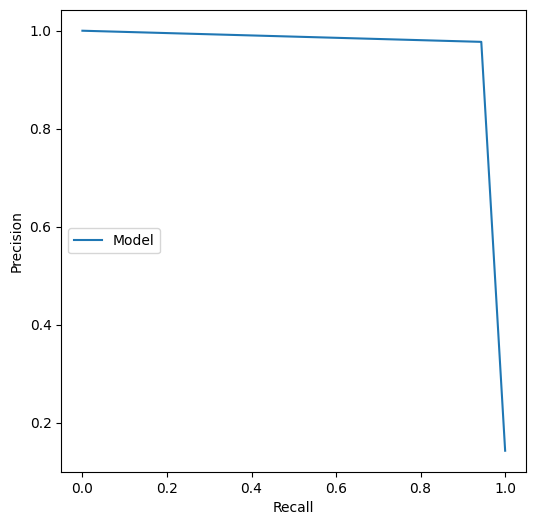

In [34]:
pred = model.predict(X_test)

pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)

CNN + LSTM

In [35]:
def CNN_LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,64,input_length=max_len)(inputs)
    layer = Convolution1D(filters=32, kernel_size=3, input_shape=(max_len, 64))(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    # layer = ReLU()(layer)

    layer = LSTM(64)(layer)

    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)

    return model

model = CNN_LSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 150, 64)        │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 148, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 74, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,073 (371.38 KB)

 Trainable params: 95,073 (371.38 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(X_train, Y_train,batch_size=128,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8224 - loss: 0.3739 - val_accuracy: 0.9698 - val_loss: 0.1196
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9722 - loss: 0.0981 - val_accuracy: 0.9720 - val_loss: 0.1174
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9820 - loss: 0.0628 - val_accuracy: 0.9877 - val_loss: 0.0472
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9895 - loss: 0.0416 - val_accuracy: 0.9911 - val_loss: 0.0401
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9925 - loss: 0.0350 - val_accuracy: 0.9905 - val_loss: 0.0370
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9898 - loss: 0.0331 - val_accuracy: 0.9905 - val_loss: 0.0351
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9954 - loss: 0.0175 - val_accuracy: 0.9927 - val_loss: 0.0335
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9961 - loss: 0.0202 - val_accuracy: 0.9922 - va

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      1916
        Spam       0.96      0.96      0.96       319

    accuracy                           0.99      2235
   macro avg       0.97      0.98      0.98      2235
weighted avg       0.99      0.99      0.99      2235



,Predicted Ham,Predicted Spam
Ham,1902,14
Spam,13,306


Accuracy: 0.98792


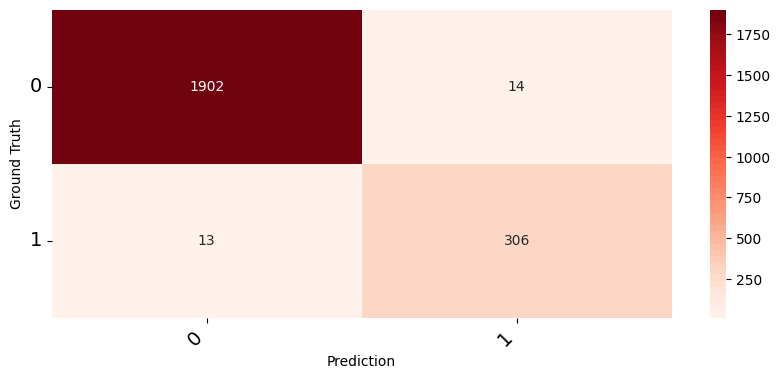

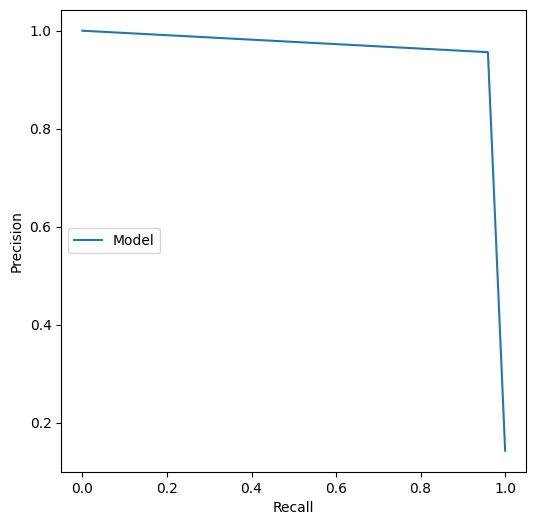

In [37]:
pred = model.predict(X_test)
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

eval_result(X_test, Y_test.reshape(len(Y_test), ), pred)